In [1]:
# Do NOT run this cell more than once
import sys
sys.path[0] += "/.."

In [2]:
from typing import List
import importlib

import torch
import torchvision.datasets as datasets
from torchvision.transforms import v2
import matplotlib.pyplot as plt

import models

---

In [3]:
EPOCHS = 5
BATCH_SIZE = 32
GPU = torch.cuda.is_available()
ROOT = "../data/mnist"

In [4]:
transforms = [
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize((0.5,), (0.5,))  # need to provide iterable
]

In [5]:
def get_loader(train: bool, transforms: List, batches: int):
    set = datasets.MNIST(root=ROOT, train=train, download=True, transform=v2.Compose(transforms))
    return torch.utils.data.DataLoader(set, batch_size=batches, shuffle=True)

---

In [ ]:
train_loader = get_loader(train=True, transforms=transforms, batches=BATCH_SIZE)
test_loader = get_loader(train=False, transforms=transforms, batches=BATCH_SIZE)

# MLP

In [ ]:
mlp = models.mlp.MLP()
optimizer = torch.optim.SGD(mlp.parameters(), lr=0.01, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()

##### Sample pass

In [ ]:
y = torch.tensor([0, 8, 1, 1, 3, 0, 2, 2, 3, 1, 1, 4, 6, 0, 6, 3, 9, 1, 5, 8, 1, 3, 2, 5, 0, 5, 9, 2, 5, 8, 8, 3])
y_hat = mlp(next(iter(train_loader))[0])
print(criterion(y_hat.squeeze(axis=1), y))
print(y_hat.shape)

tensor(2.3121, grad_fn=<NllLossBackward0>)
torch.Size([32, 1, 10])


- `y`: 1 x 32, values ranging from (0, NUM_Y_HAT_COLS - 1)
- `y_hat`: 32 x 10

In [ ]:
if GPU:
    mlp.to('cuda')
for epoch in range(EPOCHS):
    for img, label in train_loader:
        if GPU:
            img, label = img.to('cuda'), label.to('cuda')
        out = mlp(img).squeeze(axis=1)
        loss = criterion(out, label)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()
    print(f"Epoch {epoch} loss={loss.item()}")

- We squeeze the output matrix on axis 1, as the forward pass outputs shape [32, 1, 10]. 
- Cross-entropy loss expects class indices for target variable. `y` shape is [32], `y_hat` shape is [32, 10], where each of 32 points has raw outputs from output layer.

---

# Small CNN

In [ ]:
cnn_small = models.cnn.CNN_small()
if GPU:
    cnn_small.to('cuda')
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=cnn_small.parameters(), lr=0.01, momentum=0.9)

---

# LeNet-5

In [17]:
importlib.reload(models)

<module 'models' from '/home/parxed/code/projects/papersfromscratch/notebooks/../models/__init__.py'>

In [6]:
train_loader = get_loader(train=True, transforms=transforms + [v2.Resize([32, 32])], batches=BATCH_SIZE)
test_loader = get_loader(train=False, transforms=transforms + [v2.Resize([32, 32])], batches=BATCH_SIZE)

/home/parxed/code/projects/VENVS/ml-scratch/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([1, 32, 32])

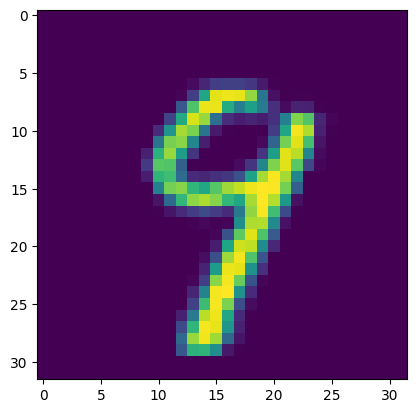

In [7]:
img = next(iter(train_loader))[0][0]
plt.imshow(img.numpy().squeeze())
img.shape

In [8]:
lenet = models.lenet.LeNet5()
first_layer = next(lenet.children())(img)
# plt.imshow(lenet(img).detach().numpy()[0, :, :])
# lenet(img).shape
first_layer.shape

torch.Size([6, 28, 28])

In [13]:
lenet(img).shape

torch.Size([6, 14, 14])